In [43]:
import pandas as pd
import numpy as np
import datetime
import os

In [44]:
# Define the folder path containing your CSV files
folder_path = r"C:\Users\sande\OneDrive\Desktop\power BI\Supply Chain Anomaly Detection\Ecommerce Order Dataset\Filtered-data"

# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Load each file into a separate DataFrame
for file in csv_files:
    file_name = os.path.splitext(file)[0]  # Remove the .csv extension
    file_path = os.path.join(folder_path, file)  # Full path to the file
    globals()[file_name] = pd.read_csv(file_path)  # Create a variable dynamically

    # Display confirmation and preview
    print(f"Loaded file: {file_name}")
    print(globals()[file_name].head(1))  # Preview the DataFrame


Loaded file: Dim_Customers_filtered
    customer_id  customer_zip_code_prefix    customer_city customer_state
0  hCT0x9JiGXBQ                     58125  varzea paulista             SP
Loaded file: Dim_OrderItems_filtered
       order_id    product_id     seller_id   price  shipping_charges
0  Axfy13Hk4PIk  90K0C1fIyQUf  ZWM05J9LcBSF  223.51             84.65
Loaded file: Dim_Payments_filtered
       order_id  payment_sequential payment_type  payment_installments  \
0  Axfy13Hk4PIk                   1  credit_card                     1   

   payment_value  
0         259.14  
Loaded file: Dim_Products_filtered
     product_id product_category_name  product_weight_g  product_length_cm  \
0  90K0C1fIyQUf                  toys             491.0               19.0   

   product_height_cm  product_width_cm  
0               12.0              16.0  
Loaded file: Fact_Orders_filtered
       order_id   customer_id order_status order_purchase_timestamp  \
0  Axfy13Hk4PIk  hCT0x9JiGXBQ    deliv

In [45]:
Fact_Orders_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89316 entries, 0 to 89315
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   order_id                              89316 non-null  object 
 1   customer_id                           89316 non-null  object 
 2   order_status                          89316 non-null  object 
 3   order_purchase_timestamp              89316 non-null  object 
 4   order_approved_at                     89307 non-null  object 
 5   order_delivered_timestamp             87427 non-null  object 
 6   order_estimated_delivery_date         89316 non-null  object 
 7   delivery_to_estimated_delivery_delay  87427 non-null  float64
dtypes: float64(1), object(7)
memory usage: 5.5+ MB


In [46]:

# Convert the relevant columns to datetime
Fact_Orders_filtered['order_purchase_timestamp'] = pd.to_datetime(Fact_Orders_filtered['order_purchase_timestamp'])
Fact_Orders_filtered['order_delivered_timestamp'] = pd.to_datetime(Fact_Orders_filtered['order_delivered_timestamp'])
Fact_Orders_filtered['order_approved_at'] = pd.to_datetime(Fact_Orders_filtered['order_approved_at'])
Fact_Orders_filtered['order_estimated_delivery_date'] = pd.to_datetime(Fact_Orders_filtered['order_estimated_delivery_date'])

# Calculate additional features
Fact_Orders_filtered['order_duration'] = (Fact_Orders_filtered['order_delivered_timestamp'] - Fact_Orders_filtered['order_purchase_timestamp']).dt.total_seconds() / (3600 * 24)
Fact_Orders_filtered['approval_delay'] = (Fact_Orders_filtered['order_approved_at'] - Fact_Orders_filtered['order_purchase_timestamp']).dt.total_seconds() / (3600 * 24)
Fact_Orders_filtered['delivery_accuracy'] = (Fact_Orders_filtered['order_estimated_delivery_date'] - Fact_Orders_filtered['order_delivered_timestamp']).dt.total_seconds() / (3600 * 24)



In [47]:
Fact_Orders_filtered.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_to_estimated_delivery_delay,order_duration,approval_delay,delivery_accuracy
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,4.140255,0.011331,13.069537


In [48]:
# Merge Fact_Orders with all required dimension tables
Fact_Orders_filtered = (
    Fact_Orders_filtered
    .merge(Dim_Customers_filtered, on='customer_id', how='left')  # Merge Customers dimension table
    .merge(Dim_OrderItems_filtered, on='order_id', how='left')   # Merge Fact_Orders with Order_Items to get product_id
    .merge(Dim_Products_filtered, on='product_id', how='left')   # Merge Products dimension table
)


In [49]:
Fact_Orders_filtered.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_to_estimated_delivery_delay,order_duration,approval_delay,...,customer_state,product_id,seller_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,delivered,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,4.140255,0.011331,...,SP,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65,toys,491.0,19.0,12.0,16.0


In [50]:
# Extract weekday (0=Monday, 6=Sunday)
Fact_Orders_filtered['order_purchase_weekday'] = Fact_Orders_filtered['order_purchase_timestamp'].dt.weekday
Fact_Orders_filtered['order_purchase_is_weekend'] = (Fact_Orders_filtered['order_purchase_weekday'] >= 5).astype(int)  # 1 for weekend, 0 for weekday

# Time-based trends might influence delivery delays, so extracting month and year could be helpful.
Fact_Orders_filtered['order_purchase_month'] = Fact_Orders_filtered['order_purchase_timestamp'].dt.month
Fact_Orders_filtered['order_purchase_year'] = Fact_Orders_filtered['order_purchase_timestamp'].dt.year

#Number of Orders per Customer: How many orders has a customer placed in the past? This could give insight into customer behavior.
Fact_Orders_filtered['customer_order_count'] = Fact_Orders_filtered.groupby('customer_id')['order_id'].transform('count')

#Customer Delivery Delays: The average delivery delay for each customer could indicate an anomaly if a particular customer is consistently delayed.
Fact_Orders_filtered['customer_avg_delivery_delay'] = Fact_Orders_filtered.groupby('customer_id')['delivery_to_estimated_delivery_delay'].transform('mean')

#Product Weight-to-Price Ratio: This can give insights into whether heavier or more expensive products are more likely to cause delays.
Fact_Orders_filtered['product_weight_to_price'] = Fact_Orders_filtered['product_weight_g'] / Fact_Orders_filtered['price']

#Product Dimensions: dimensions (length, height, width) into a single volume feature, as larger products may cause delays or anomalies in the supply chain.
Fact_Orders_filtered['product_volume'] = (Fact_Orders_filtered['product_length_cm'] * Fact_Orders_filtered['product_width_cm'] * Fact_Orders_filtered['product_height_cm'])

#Product Category: product categories into numerical features for machine learning models.
Fact_Orders_filtered['product_category_name'] = Fact_Orders_filtered['product_category_name'].astype('category')
Fact_Orders_filtered['product_category_code'] = Fact_Orders_filtered['product_category_name'].cat.codes

#Price to Shipping Charges Ratio: unusually high shipping charges might be correlated with certain issues in the supply chain, such as distant delivery locations.

Fact_Orders_filtered['price_to_shipping_ratio'] = Fact_Orders_filtered['price'] / (Fact_Orders_filtered['shipping_charges'] + 1e-6)  # Adding a small constant to avoid division by zero

#Seller Delivery Delay: Calculate the average delay for each seller.
Fact_Orders_filtered['seller_avg_delivery_delay'] = Fact_Orders_filtered.groupby('seller_id')['delivery_to_estimated_delivery_delay'].transform('mean')


#One-Hot Encoding for order_status: Convert the order status into multiple binary columns
Fact_Orders_filtered = pd.get_dummies(Fact_Orders_filtered, columns=['order_status'], drop_first=True)

#Label Encoding for customer_state: If you want to keep the customer state as a feature, use label encoding.
Fact_Orders_filtered['customer_state'] = Fact_Orders_filtered['customer_state'].astype('category')
Fact_Orders_filtered['customer_state_code'] = Fact_Orders_filtered['customer_state'].cat.codes



In [51]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'product_category_name' column
if 'product_category_name' in Fact_Orders_filtered.columns:
    le = LabelEncoder()
    Fact_Orders_filtered['product_category_name_encoded'] = le.fit_transform(Fact_Orders_filtered['product_category_name'])

In [52]:
Fact_Orders_filtered[Fact_Orders_filtered['order_approved_at'].isnull()]

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_to_estimated_delivery_delay,order_duration,approval_delay,delivery_accuracy,...,price_to_shipping_ratio,seller_avg_delivery_delay,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,customer_state_code,product_category_name_encoded
287490,4Itts2TBUQzs,Z3dI7uRBfJOD,2017-02-17 13:05:55,NaT,2017-03-02 11:09:19,2017-03-20,-18.0,12.919028,NaN,17.535197,...,2.409788,-11.814975,False,True,False,False,False,False,18,20
287491,4Itts2TBUQzs,Z3dI7uRBfJOD,2017-02-17 13:05:55,NaT,2017-03-02 11:09:19,2017-03-20,-18.0,12.919028,NaN,17.535197,...,2.409788,-11.814975,False,True,False,False,False,False,18,20
287492,4Itts2TBUQzs,Z3dI7uRBfJOD,2017-02-17 13:05:55,NaT,2017-03-02 11:09:19,2017-03-20,-18.0,12.919028,NaN,17.535197,...,2.409788,-11.814975,False,True,False,False,False,False,18,20
287493,4Itts2TBUQzs,Z3dI7uRBfJOD,2017-02-17 13:05:55,NaT,2017-03-02 11:09:19,2017-03-20,-18.0,12.919028,NaN,17.535197,...,2.409788,-11.814975,False,True,False,False,False,False,18,20
287494,4Itts2TBUQzs,Z3dI7uRBfJOD,2017-02-17 13:05:55,NaT,2017-03-02 11:09:19,2017-03-20,-18.0,12.919028,NaN,17.535197,...,2.409788,-11.814975,False,True,False,False,False,False,18,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838649,Uso7EoEPMrLU,rKJOxQc2PTfc,2017-01-19 22:26:59,NaT,2017-02-06 14:22:19,2017-03-16,-38.0,17.663426,NaN,37.401169,...,108.353614,-14.923237,False,True,False,False,False,False,10,69
1838650,Uso7EoEPMrLU,rKJOxQc2PTfc,2017-01-19 22:26:59,NaT,2017-02-06 14:22:19,2017-03-16,-38.0,17.663426,NaN,37.401169,...,108.353614,-14.923237,False,True,False,False,False,False,10,69
1838651,Uso7EoEPMrLU,rKJOxQc2PTfc,2017-01-19 22:26:59,NaT,2017-02-06 14:22:19,2017-03-16,-38.0,17.663426,NaN,37.401169,...,108.353614,-14.923237,False,True,False,False,False,False,10,69
1838652,Uso7EoEPMrLU,rKJOxQc2PTfc,2017-01-19 22:26:59,NaT,2017-02-06 14:22:19,2017-03-16,-38.0,17.663426,NaN,37.401169,...,108.353614,-14.923237,False,True,False,False,False,False,10,69


In [53]:
#Many features have different units or ranges. For example:
#order_duration might be measured in hours (0–100+).
#price could range from a few dollars to thousands.
#product_weight_g is in grams and can range from a few grams to tens of thousands.
#Machine learning models (e.g., KNN, SVM, neural networks) can struggle when features have vastly different scales, as some features might dominate others during training.

In [54]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Columns to scale
scaled_columns = ['order_duration', 'approval_delay', 'delivery_accuracy', 'price', 'shipping_charges', 'product_weight_g']

# Fit the scaler to the data and transform it
Fact_Orders_filtered[scaled_columns] = scaler.fit_transform(Fact_Orders_filtered[scaled_columns])

# Check scaled data
print(Fact_Orders_filtered[scaled_columns].head())




   order_duration  approval_delay  delivery_accuracy     price  \
0       -1.002697       -0.521085            0.24783 -0.345145   
1       -1.002697       -0.521085            0.24783 -0.345145   
2       -1.002697       -0.521085            0.24783 -0.345145   
3       -1.002697       -0.521085            0.24783 -0.345145   
4       -1.002697       -0.521085            0.24783 -0.345145   

   shipping_charges  product_weight_g  
0          1.130852          -0.51972  
1          1.130852          -0.51972  
2          1.130852          -0.51972  
3          1.130852          -0.51972  
4          1.130852          -0.51972  


In [55]:
Fact_Orders_filtered.head(1)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_to_estimated_delivery_delay,order_duration,approval_delay,delivery_accuracy,...,price_to_shipping_ratio,seller_avg_delivery_delay,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,customer_state_code,product_category_name_encoded
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,-1.002697,-0.521085,0.24783,...,2.640402,-10.210078,False,True,False,False,False,False,25,69


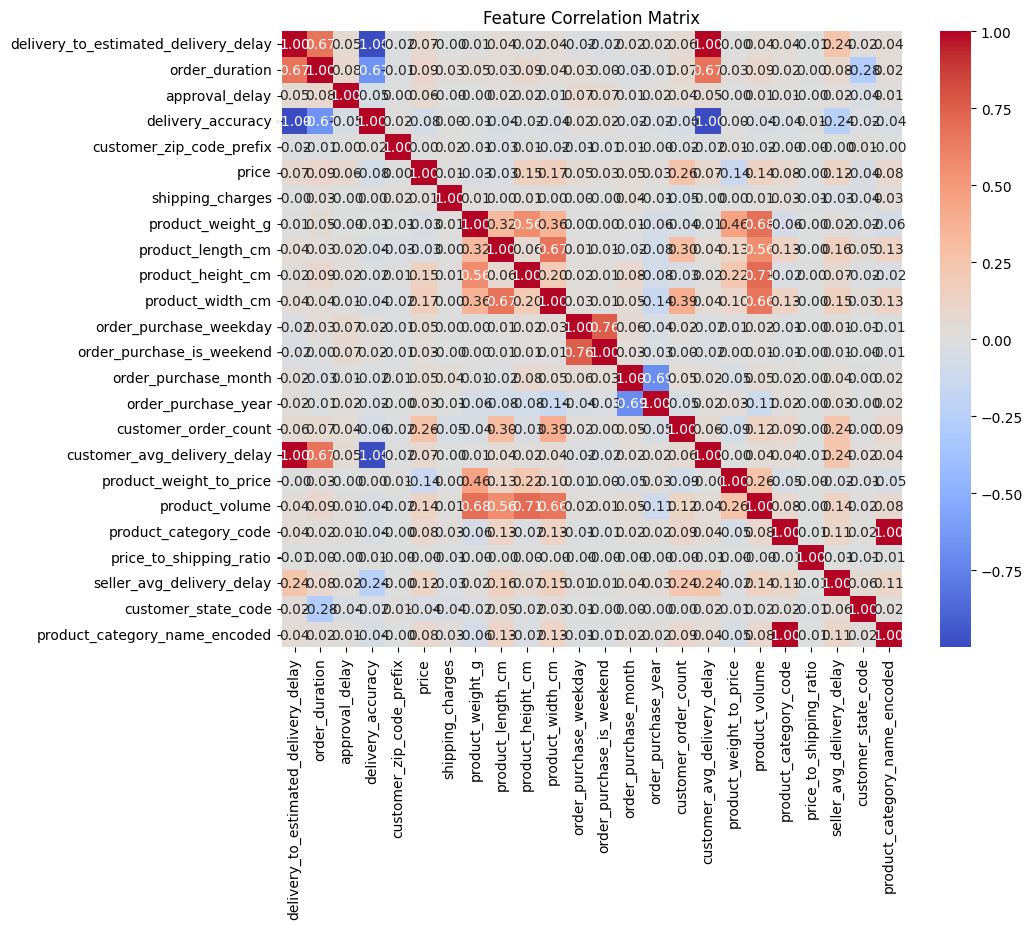

In [56]:

import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = Fact_Orders_filtered.select_dtypes(include=[np.number])

# Calculate correlation matrix
corr_matrix = numerical_columns.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()



In [57]:
#identify pairs of features with high correlations (e.g., above 0.8 or below -0.8). These can cause issues in predictive models like regression.

# Set correlation threshold
threshold = 0.85

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify features with correlation above the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop redundant features
Fact_Orders_filtered.drop(columns=to_drop, inplace=True)

# Output dropped features and updated DataFrame shape
print(f"Dropped features due to high correlation: {to_drop}")
print(f"Updated DataFrame shape: {Fact_Orders_filtered.shape}")




Dropped features due to high correlation: ['customer_avg_delivery_delay', 'product_category_name_encoded']
Updated DataFrame shape: (2529486, 39)


In [58]:
# Step 1: Identify and count NaN values
null_counts = Fact_Orders_filtered[scaled_columns].isnull().sum()
print("Null counts before dropping:")
print(null_counts)

# Step 2: Drop rows with NaN values
Fact_Orders_filtered_cleaned = Fact_Orders_filtered.dropna(subset=scaled_columns)

# Step 3: Verify that NaN values are removed
print("Null counts after dropping:")
print(Fact_Orders_filtered_cleaned[scaled_columns].isnull().sum())


Null counts before dropping:
order_duration       36051
approval_delay         199
delivery_accuracy    36051
price                    0
shipping_charges         0
product_weight_g         0
dtype: int64
Null counts after dropping:
order_duration       0
approval_delay       0
delivery_accuracy    0
price                0
shipping_charges     0
product_weight_g     0
dtype: int64


In [59]:
Fact_Orders_filtered_cleaned.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_to_estimated_delivery_delay,order_duration,approval_delay,delivery_accuracy,...,product_category_code,price_to_shipping_ratio,seller_avg_delivery_delay,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,customer_state_code
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,-1.002697,-0.521085,0.24783,...,69,2.640402,-10.210078,False,True,False,False,False,False,25
1,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,-1.002697,-0.521085,0.24783,...,69,2.640402,-10.210078,False,True,False,False,False,False,25
2,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,-1.002697,-0.521085,0.24783,...,69,2.640402,-10.210078,False,True,False,False,False,False,25
3,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,-1.002697,-0.521085,0.24783,...,69,2.640402,-10.210078,False,True,False,False,False,False,25
4,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,-14.0,-1.002697,-0.521085,0.24783,...,69,2.640402,-10.210078,False,True,False,False,False,False,25


In [60]:
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# Step 1: Initialize the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)  # can Adjust contamination as needed

# Step 2: Fit the model to the cleaned data
anomalies = isolation_forest.fit_predict(Fact_Orders_filtered_cleaned[scaled_columns])

# Step 3: Add anomaly column
Fact_Orders_filtered_cleaned['anomaly'] = anomalies == -1  # True for anomalies, False for normal points

# Step 4: Count total anomalies and normal points
total_anomalies = Fact_Orders_filtered_cleaned['anomaly'].sum()
total_normal_points = len(Fact_Orders_filtered_cleaned) - total_anomalies

print(f"Total anomalies detected: {total_anomalies}")
print(f"Total normal points: {total_normal_points}")

# Step 5: Save anomalies to CSV file
anomalies_df = Fact_Orders_filtered_cleaned[Fact_Orders_filtered_cleaned['anomaly']]

csv_path = r"C:\Users\sande\OneDrive\Desktop\power BI\Supply Chain Anomaly Detection\Anomalies Identified\Anomalies.csv"
anomalies_df.to_csv(csv_path, index=False)

print(f"Anomalies saved to {csv_path}")

# Step 6: Save the trained Isolation Forest model
model_path = r"C:\Users\sande\OneDrive\Desktop\power BI\Supply Chain Anomaly Detection\Model\IsolationForest_model.pkl"
joblib.dump(isolation_forest, model_path)

print(f"Model saved to {model_path}")



C:\Users\sande\AppData\Local\Temp\ipykernel_18856\452699876.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fact_Orders_filtered_cleaned['anomaly'] = anomalies == -1  # True for anomalies, False for normal points


Total anomalies detected: 124640
Total normal points: 2368596
Anomalies saved to C:\Users\sande\OneDrive\Desktop\power BI\Supply Chain Anomaly Detection\Anomalies Identified\Anomalies.csv
Model saved to C:\Users\sande\OneDrive\Desktop\power BI\Supply Chain Anomaly Detection\Model\IsolationForest_model.pkl


In [61]:
anomalies_df.head(1)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_to_estimated_delivery_delay,order_duration,approval_delay,delivery_accuracy,...,price_to_shipping_ratio,seller_avg_delivery_delay,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,customer_state_code,anomaly
63,VEDSMTavbQwk,gDdkaN8b9s1g,2018-02-23 14:49:39,2018-02-23 15:16:13,2018-04-02 14:12:50,2018-03-15,18.0,2.6495,-0.51296,-3.079824,...,22.943198,-10.153225,False,True,False,False,False,False,25,True


In [62]:
total_points = len(Fact_Orders_filtered_cleaned)
anomaly_percentage = (total_anomalies / total_points) * 100
print(f"Percentage of anomalies detected: {anomaly_percentage:.2f}%")


Percentage of anomalies detected: 5.00%


In [67]:
anomalies_df

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,delivery_to_estimated_delivery_delay,order_duration,approval_delay,delivery_accuracy,...,price_to_shipping_ratio,seller_avg_delivery_delay,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,customer_state_code,anomaly
63,VEDSMTavbQwk,gDdkaN8b9s1g,2018-02-23 14:49:39,2018-02-23 15:16:13,2018-04-02 14:12:50,2018-03-15,18.0,2.649500,-0.512960,-3.079824,...,22.943198,-10.153225,False,True,False,False,False,False,25,True
1586,lo8oje94TYb7,eSqRKROmKF9Y,2018-08-13 14:07:50,2018-08-15 03:15:09,2018-08-24 00:14:39,2018-09-05,-12.0,-0.324685,1.231540,0.134353,...,1.531304,-9.000000,False,True,False,False,False,False,23,True
1587,lo8oje94TYb7,eSqRKROmKF9Y,2018-08-13 14:07:50,2018-08-15 03:15:09,2018-08-24 00:14:39,2018-09-05,-12.0,-0.324685,1.231540,0.134353,...,1.531304,-9.000000,False,True,False,False,False,False,23,True
1724,NnoGZNF5rNkD,YanexVtkhb2B,2017-11-17 19:41:48,2017-11-18 02:35:30,2017-12-02 18:38:16,2017-12-05,-3.0,0.164785,-0.206085,-0.892096,...,9.084721,-8.204082,False,True,False,False,False,False,25,True
1725,NnoGZNF5rNkD,YanexVtkhb2B,2017-11-17 19:41:48,2017-11-18 02:35:30,2017-12-02 18:38:16,2017-12-05,-3.0,0.164785,-0.206085,-0.892096,...,9.084721,-8.204082,False,True,False,False,False,False,25,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2529480,v3QtU6xlGDJp,auSfRYUQUOIq,2018-08-11 08:04:22,2018-08-11 08:24:40,2018-08-14 21:43:51,2018-08-17,-3.0,-1.064352,-0.517927,-0.905641,...,25.652597,-11.745399,False,True,False,False,False,False,25,True
2529481,v3QtU6xlGDJp,auSfRYUQUOIq,2018-08-11 08:04:22,2018-08-11 08:24:40,2018-08-14 21:43:51,2018-08-17,-3.0,-1.064352,-0.517927,-0.905641,...,25.652597,-11.745399,False,True,False,False,False,False,25,True
2529482,v3QtU6xlGDJp,auSfRYUQUOIq,2018-08-11 08:04:22,2018-08-11 08:24:40,2018-08-14 21:43:51,2018-08-17,-3.0,-1.064352,-0.517927,-0.905641,...,25.652597,-11.745399,False,True,False,False,False,False,25,True
2529483,v3QtU6xlGDJp,auSfRYUQUOIq,2018-08-11 08:04:22,2018-08-11 08:24:40,2018-08-14 21:43:51,2018-08-17,-3.0,-1.064352,-0.517927,-0.905641,...,25.652597,-11.745399,False,True,False,False,False,False,25,True
